# Demand Forecaster

## 1) Business problem

URL Project: [Sales Prediction for Big Mart Outlets](https://www.kaggle.com/datasets/shivan118/big-mart-sales-prediction-datasets?select=test.csv)

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet.

Using this model, BigMart will try to understand the properties of products and outlets which play a key role in increasing sales.

Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.

**Data Dictionary**

We have a train (8523) and test (5681) data set, the train data set has both input and output variable(s). You need to predict the sales for the test data set.

#### Train file:
CSV containing the item outlet information with a sales value

**Variable Description**
* *Item_Identifier*: Unique product ID
* *Item_Weight*: Weight of product
* *Item_Fat_Content*: Whether the product is low fat or not
* *Item_Visibility*: The % of the total display area of all products in a store allocated to the particular product
* *Item_Type*: The category to which the product belongs
* *Item_MRP*: Maximum Retail Price (list price) of the product
* *Outlet_Identifier*: Unique store ID
* *Outlet_Establishment_Year*: The year in which the store was established
* *Outlet_Size*: The size of the store in terms of ground area covered
* *Outlet_Location_Type*: The type of city in which the store is located
* *Outlet_Type*: Whether the outlet is just a grocery store or some sort of supermarket
* *Item_Outlet_Sales*: sales of the product in t particular store. This is the outcome variable to be predicted.

### Test file:
CSV containing item outlet combinations for which sales need to be forecasted

**Variable Description**
* *Item_Identifier*:  Unique product ID
* *Item_Weight*: Weight of product
* *Item_Fat_Content*:  Whether the product is low fat or not
* *Item_Visibility*: The % of the total display area of all products in a store allocated to the particular product
* *Item_Type*: The category to which the product belongs
* *Item_MRP*:  Maximum Retail Price (list price) of the product
* *Outlet_Identifier*:  Unique store ID
* *Outlet_Establishment_Year*:  The year in which store store was established
* *Outlet_Size*:  The size of the store in terms of ground area covered
* *Outlet_Location_Type*: The type of city in which the store is located
* *Outlet_Type*: whether the outlet is just a grocery store or some sort of supermarket

### Submission file format
**Variable Description**
* *Item_Identifier*:  Unique product ID
* *Outlet_Identifier*:  Unique store ID
* *Item_Outlet_Sales*:  Sales of the product in t particular store. This is the outcome variable to be predicted.

**Evaluation Metric**

Your model performance will be evaluated on the basis of your prediction of the sales for the test data (test.csv), which contains similar data-points as train except for the sales to be predicted. Your submission needs to be in the format as shown in the same sample submission.

We at our end, have the actual sales for the test dataset, against which your predictions will be evaluated. We will use the Root Mean Square Error value to judge your response.

### 1.1) Imports and Load Data

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import normaltest, zscore
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import missingno

from sklearn.metrics import mean_absolute_percentage_error, r2_score

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
sns.set_context("paper")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### 1.2) Utilities Functions

In [3]:
def currencyFormatting(value):
    if value / 1000000 > 1:
        return f'$ {str(round(value/1000000, 2))}M'
    elif value / 100000 > 1:
        return f'$ {str(round(value/100000, 2))}KK'
    elif value / 1000 > 1:
        return f'$ {str(round(value/10000, 2))}k'
    else: 
        return f'$ {str(round(value, 2))}'

In [4]:
def resumeNumber(value):
    if value / 1000000 > 1:
        return f'{str(round(value/1000000, 2))}M'
    elif value / 100000 > 1:
        return f'{str(round(value/100000, 2))}KK'
    elif value / 1000 > 1:
        return f'{str(round(value/10000, 2))}k'
    else: 
        return f'{str(round(value, 2))}'

## 2) EDA - Exploratory Data Analysis

In [5]:
df_train_raw = pd.read_csv('../data/train.csv')
df_valid_raw = pd.read_csv('../data/test.csv')

In [6]:
display(df_train_raw.shape)
display(df_train_raw.head())

(8523, 12)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [7]:
display(df_valid_raw.shape)
display(df_valid_raw.head())

(5681, 11)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [8]:
df_train_raw.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [9]:
df_valid_raw.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [10]:
df_train_raw.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [11]:
df_train_raw.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


# 3) Divisão dos dados em Treino e Teste

In [12]:
features_columns = [
    'Item_Identifier', 
    'Item_Weight', 
    'Item_Fat_Content', 
    'Item_Visibility',
    'Item_Type', 
    'Item_MRP', 
    'Outlet_Identifier',
    'Outlet_Establishment_Year', 
    'Outlet_Size', 
    'Outlet_Location_Type',
    'Outlet_Type'
]

target_column = ['Item_Outlet_Sales']

In [13]:
x_train, x_test, y_train, y_test = train_test_split(df_train_raw[features_columns], df_train_raw[target_column])

In [14]:
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [15]:
display(x_train.head(3))
display(x_test.head(3))

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,NCF31,9.13,Low Fat,0.051953,Household,152.3024,OUT045,2002,NaN,Tier 2,Supermarket Type1
1,FDG09,20.60,Regular,0.047927,Fruits and Vegetables,185.9556,OUT035,2004,Small,Tier 2,Supermarket Type1
2,FDM60,10.80,Regular,0.048143,Baking Goods,40.2138,OUT046,1997,Small,Tier 1,Supermarket Type1


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDB03,17.75,Regular,0.156832,Dairy,241.0538,OUT046,1997,Small,Tier 1,Supermarket Type1
1,FDI41,18.50,reg,0.062609,Frozen Foods,148.6418,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCE31,7.67,Low Fat,0.185597,Household,35.7216,OUT018,2009,Medium,Tier 3,Supermarket Type2


In [16]:
display(y_train.head(3))
display(y_test.head(3))

,Item_Outlet_Sales
0,1821.6288
1,4318.3788
2,690.4346


,Item_Outlet_Sales
0,1201.7690
1,1765.7016
2,69.2432


# 4) Lidando com dados outliers

**Item_Identifier**

In [17]:
x_train['Item_Identifier'].value_counts()

Item_Identifier
FDD38    9
FDW13    9
FDG33    9
FDV38    9
NCX05    8
        ..
FDR03    1
FDE47    1
FDH52    1
FDZ50    1
FDU43    1
Name: count, Length: 1547, dtype: int64

Essa variável não tem muito o que fazer, embora itens que aparecem apenas uma vez podem ser uma pedra no sapato.

**Item_Weight**

<Axes: xlabel='Item_Weight'>

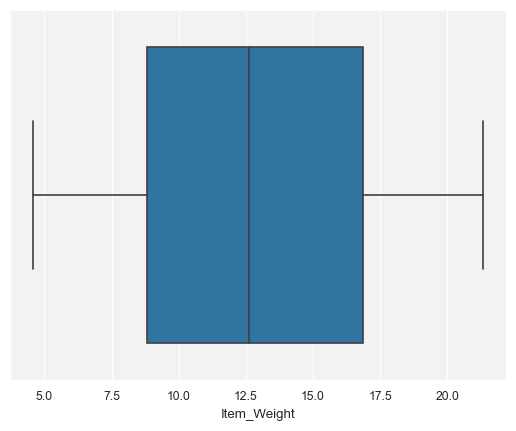

In [18]:
sns.boxplot(x=x_train['Item_Weight'])

**Item_Visibility**

<Axes: xlabel='Item_Visibility'>

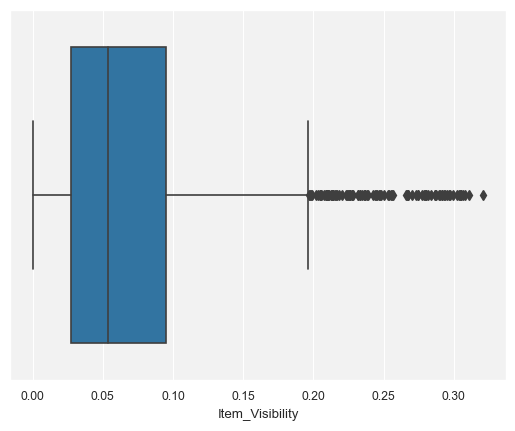

In [19]:
sns.boxplot(x=x_train['Item_Visibility'])

Esse atributo possui vários outliers. Mas como foi analisado no projeto de análise de dados, não necessariamente os outliers significam erros. Aqui são itens que possuem alta visibilidade nas prateleiras das lojas.

**Item_MRP**

<Axes: xlabel='Item_MRP'>

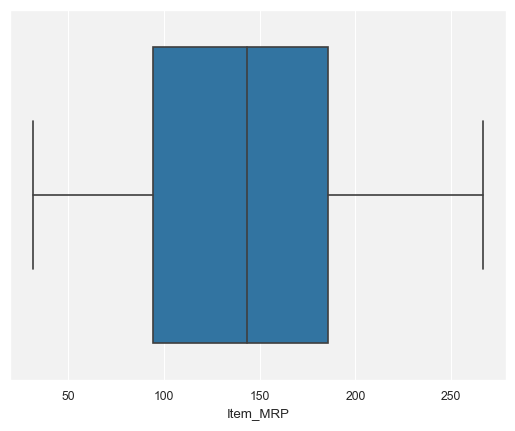

In [20]:
sns.boxplot(x=x_train['Item_MRP'])

**Item_Fat_Content**

In [21]:
x_train['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    3845
Regular    2131
LF          242
reg          92
low fat      82
Name: count, dtype: int64

Temos que lidar com esses itens aqui.

**Item_Type**

In [22]:
x_train['Item_Type'].value_counts()

Item_Type
Fruits and Vegetables    944
Snack Foods              909
Household                700
Frozen Foods             641
Dairy                    511
Canned                   473
Baking Goods             461
Health and Hygiene       400
Soft Drinks              339
Meat                     307
Breads                   181
Hard Drinks              156
Others                   120
Starchy Foods            107
Breakfast                 86
Seafood                   57
Name: count, dtype: int64

Pode-se dizer que está desbalanceado, mas a quantidade de registros pode ser suficiente para o modelo conseguir aprender.

**Outlet_Identifier**

In [23]:
x_train['Outlet_Identifier'].value_counts()

Outlet_Identifier
OUT045    714
OUT013    710
OUT027    698
OUT046    692
OUT018    692
OUT049    691
OUT035    689
OUT017    684
OUT010    417
OUT019    405
Name: count, dtype: int64

Está ok.

**Outlet_Establishment_Year**

In [24]:
x_train['Outlet_Establishment_Year'].value_counts()

Outlet_Establishment_Year
1985    1103
2002     714
1987     710
1997     692
2009     692
1999     691
2004     689
2007     684
1998     417
Name: count, dtype: int64

Está ok, embora eu acredite que essa variável seja irrelevante para o modelo.

**Outlet_Size**

In [25]:
x_train['Outlet_Size'].value_counts()

Outlet_Size
Medium    2081
Small     1786
High       710
Name: count, dtype: int64

Está ok.

**Outlet_Location_Type**

In [26]:
x_train['Outlet_Location_Type'].value_counts()

Outlet_Location_Type
Tier 3    2517
Tier 2    2087
Tier 1    1788
Name: count, dtype: int64

Está ok.

**Outlet_Type**

In [27]:
x_train['Outlet_Type'].value_counts()

Outlet_Type
Supermarket Type1    4180
Grocery Store         822
Supermarket Type3     698
Supermarket Type2     692
Name: count, dtype: int64

Está ok.

# 5) Tratamento de valores ausentes

In [28]:
display(x_train.shape)
x_train.isnull().sum()

(6392, 11)

Item_Identifier                 0
Item_Weight                  1103
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1815
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

**Item Weight**

In [29]:
x_train['Item_Weight'].fillna(x_train.groupby('Item_Type')['Item_Weight'].transform('mean'), inplace=True)
x_test['Item_Weight'].fillna(x_test.groupby('Item_Type')['Item_Weight'].transform('mean'), inplace=True)

Eu decidi utilizar o valor médio do Item weight agrupado por Item Type porque:
1. O atributo está bem distribuído, então não há diferença em usar a média ou a mediana (Talvez haja para departamentos).
2. O Item_Type é o atributo que possui maior correlação com o Item_Weight

**Outlet Size**

In [30]:
x_train['Outlet_Size'].fillna('-1', inplace=True)
x_test['Outlet_Size'].fillna('-1', inplace=True)

<Axes: >

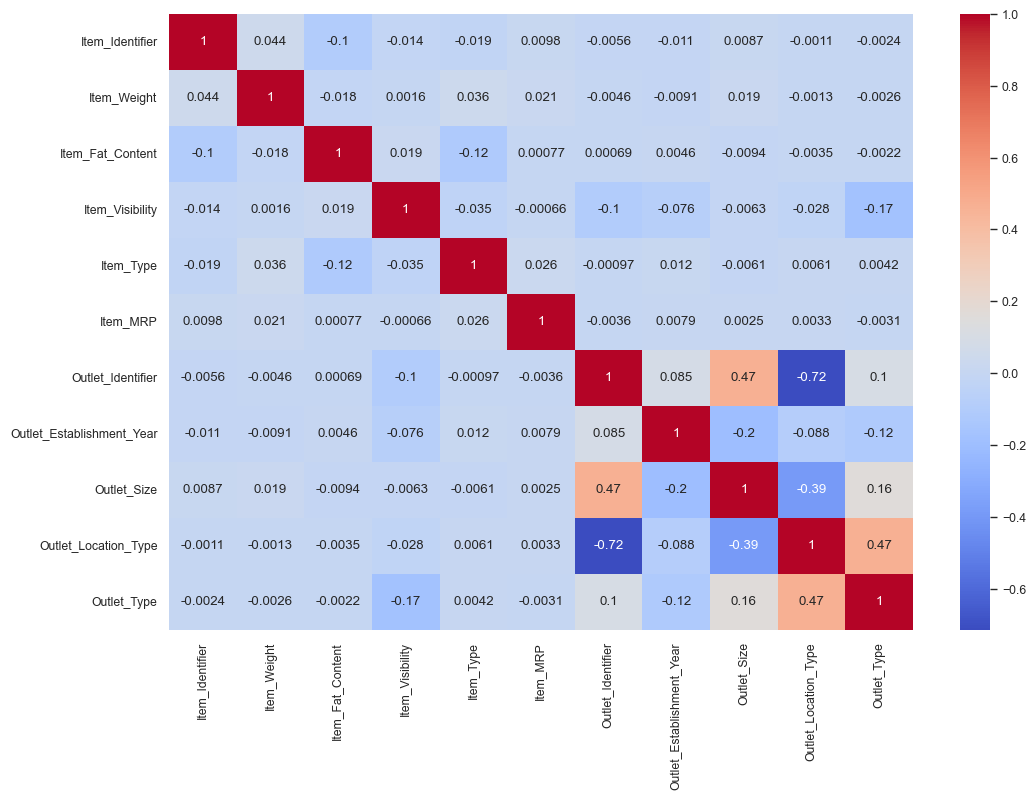

In [31]:
df_corr = x_train.copy()

le = LabelEncoder()
df_corr['Item_Identifier'] = le.fit_transform(df_corr['Item_Identifier'])
df_corr['Item_Fat_Content'] = le.fit_transform(df_corr['Item_Fat_Content'])
df_corr['Item_Type'] = le.fit_transform(df_corr['Item_Type'])
df_corr['Outlet_Identifier'] = le.fit_transform(df_corr['Outlet_Identifier'])
df_corr['Outlet_Size'] = le.fit_transform(df_corr['Outlet_Size'])
df_corr['Outlet_Location_Type'] = le.fit_transform(df_corr['Outlet_Location_Type'])
df_corr['Outlet_Type'] = le.fit_transform(df_corr['Outlet_Type'])

plt.figure(figsize=(12, 8))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm')

In [32]:
x_train.groupby(['Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'], as_index=False)['Item_Identifier'].count()

,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Identifier
0,-1,Tier 2,Supermarket Type1,1398
1,-1,Tier 3,Grocery Store,417
2,High,Tier 3,Supermarket Type1,710
3,Medium,Tier 1,Supermarket Type1,691
4,Medium,Tier 3,Supermarket Type2,692
5,Medium,Tier 3,Supermarket Type3,698
6,Small,Tier 1,Grocery Store,405
7,Small,Tier 1,Supermarket Type1,692
8,Small,Tier 2,Supermarket Type1,689


In [33]:
x_test.groupby(['Outlet_Size', 'Outlet_Location_Type'], as_index=False)['Item_Identifier'].count()

,Outlet_Size,Outlet_Location_Type,Item_Identifier
0,-1,Tier 2,457
1,-1,Tier 3,138
2,High,Tier 3,222
3,Medium,Tier 1,239
4,Medium,Tier 3,473
5,Small,Tier 1,361
6,Small,Tier 2,241


In [34]:
def fillna_outlet_size(row):
    if row.Outlet_Size == '-1':
        if row.Outlet_Location_Type == 'Tier 2':
            return 'Small'
        elif row.Outlet_Location_Type == 'Tier 3':
            return 'Medium' # Mas eu posso remover talvez.
    else: 
        return row.Outlet_Size 


In [35]:
x_train['Outlet_Size'] = x_train.apply(lambda row: fillna_outlet_size(row), axis=1)
x_test['Outlet_Size'] = x_test.apply(lambda row: fillna_outlet_size(row), axis=1)

Justificativa:
* Onde eu preenchi os valores ausentes como `Small`, foram em lojas cujo Location Type eram Tier 2, porque em todas as lojas Tier 2 eram Small;
* Onde eu preenchi os valores ausentes como `Medium`, foi igual ao valor majoritário do atributo Outlet Size cujo os Location Type eram iguais a `Tier 3`. Pode ser que essa relação não faça muito sentido e que eu tenha que mudar futuramente.

**Item_Fat_Content**

In [36]:
x_train['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    3845
Regular    2131
LF          242
reg          92
low fat      82
Name: count, dtype: int64

In [37]:
map_fat_content = {
    'Low Fat': 'Low Fat',
    'Regular': 'Regular',
    'LF': 'Low Fat',
    'reg': 'Regular',
    'low fat': 'Low Fat'
}

x_train['Item_Fat_Content'] = x_train['Item_Fat_Content'].map(map_fat_content)
x_test['Item_Fat_Content'] = x_test['Item_Fat_Content'].map(map_fat_content)

Justificativa: Como foi analisado no projeto de análise de dados, esses valores claramente se tratam de divergências no cadastro manual para o mesmo tipo de categoria. Portant, usando o pensamento lógico, percebemos que há apenas dois tipos de valores: `Low Fat` e `Regular`.

**Results**

In [38]:
display(x_train.isnull().sum())
display(x_test.isnull().sum())

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

# 6) Transformação dos atributos

* `Item_Identifier`: Ordinal Encoder ou Label Encoder
* `Item_Weight`: Padronização ou Normalização dos dados
* `Item_Fat_Content`: Label Encoder
* `Item_Visibility`: Padronização ou Normalização dos dados
* `Item_Type`: Ordinal Encoder ou One Hot Encoder
* `Item_MRP`: Padronização ou Normalização dos dados 
* `Outlet_Identifier`: Ordinal Encoder ou Label Encoder
* `Outlet_Establishment_Year`: Desconsiderar
* `Outlet_Size`: Ordinal Encoder (Testar One Hot Encoder)
* `Outlet_Location_Type`: Ordinal Encoder (Testar One Hot Encoder)
* `Outlet_Type`: Ordinal Encoder (Testar One Hot Encoder)

In [39]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder

In [40]:
x_train_transformed = x_train.copy()
x_test_transformed = x_test.copy()

**Item_Fat_Content, Outlet_Size, Outlet_Location_Type, Outlet_Type**

In [41]:
map_fat_content_encode = {
    'Regular': 0,
    'Low Fat': 1
}

map_outlet_size_encode = {
    'Small': 0, 
    'Medium': 0.5, 
    'High': 1
}

map_location_type_encode = {
    'Tier 1': 0, 
    'Tier 2': 0.5, 
    'Tier 3': 1
}

map_outlet_type_encode = {
'Grocery Store': 0, 
'Supermarket Type1': 0.33, 
'Supermarket Type2': 0.66,
'Supermarket Type3': 1, 
}

In [42]:
x_train_transformed['Item_Fat_Content'] = x_train_transformed['Item_Fat_Content'].map(map_fat_content_encode)
x_train_transformed['Outlet_Size'] = x_train_transformed['Outlet_Size'].map(map_outlet_size_encode)
x_train_transformed['Outlet_Location_Type'] = x_train_transformed['Outlet_Location_Type'].map(map_location_type_encode)
x_train_transformed['Outlet_Type'] = x_train_transformed['Outlet_Type'].map(map_outlet_type_encode)

x_test_transformed['Item_Fat_Content'] = x_test_transformed['Item_Fat_Content'].map(map_fat_content_encode)
x_test_transformed['Outlet_Size'] = x_test_transformed['Outlet_Size'].map(map_outlet_size_encode)
x_test_transformed['Outlet_Location_Type'] = x_test_transformed['Outlet_Location_Type'].map(map_location_type_encode)
x_test_transformed['Outlet_Type'] = x_test_transformed['Outlet_Type'].map(map_outlet_type_encode)

In [43]:
display(x_test_transformed['Item_Fat_Content'].value_counts())
display(x_test_transformed['Outlet_Size'].value_counts())
display(x_test_transformed['Outlet_Location_Type'].value_counts())
display(x_test_transformed['Outlet_Type'].value_counts())

Item_Fat_Content
1    1348
0     783
Name: count, dtype: int64

Outlet_Size
0.0    1059
0.5     850
1.0     222
Name: count, dtype: int64

Outlet_Location_Type
1.0    833
0.5    698
0.0    600
Name: count, dtype: int64

Outlet_Type
0.33    1397
0.00     261
1.00     237
0.66     236
Name: count, dtype: int64

In [44]:
x_test_transformed.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDB03,17.75,0,0.156832,Dairy,241.0538,OUT046,1997,0.0,0.0,0.33
1,FDI41,18.50,0,0.062609,Frozen Foods,148.6418,OUT017,2007,0.0,0.5,0.33
2,NCE31,7.67,1,0.185597,Household,35.7216,OUT018,2009,0.5,1.0,0.66
3,FDO32,6.36,1,0.120544,Fruits and Vegetables,45.8060,OUT046,1997,0.0,0.0,0.33
4,DRE13,6.28,1,0.027700,Soft Drinks,87.9198,OUT035,2004,0.0,0.5,0.33


**Outlet Identifier Ordinal**

In [45]:
ordinal_encoder = LabelEncoder()

features_encoded = ordinal_encoder.fit_transform(x_train_transformed['Outlet_Identifier'])
x_train_transformed['Outlet_Identifier_ordinal'] = features_encoded

features_encoded = ordinal_encoder.transform(x_test_transformed['Outlet_Identifier'])
x_test_transformed['Outlet_Identifier_ordinal'] = features_encoded

**Item Type**

In [46]:
ohe = OneHotEncoder(sparse=False)

Item_Type_ohe_train = ohe.fit_transform(x_train_transformed[['Item_Type']])
Item_Type_ohe_test = ohe.transform(x_test_transformed[['Item_Type']])

# columns_ohe = ['Item_Type_{}'.format(str.replace(item ,' ', '_')) for item in list(ohe.categories_[0])]
columns_ohe_train = pd.DataFrame(Item_Type_ohe_train, columns=ohe.get_feature_names_out(['Item_Type']))
columns_ohe_test = pd.DataFrame(Item_Type_ohe_test, columns=ohe.get_feature_names_out(['Item_Type']))

for row in ohe.get_feature_names_out(['Item_Type']):
    x_train_transformed[row.replace(' ', '_')] = columns_ohe_train[row]
    x_test_transformed[row.replace(' ', '_')] = columns_ohe_test[row]

In [47]:
x_train_transformed.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Identifier_ordinal,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks,Item_Type_Starchy_Foods
0,NCF31,9.13,1,0.051953,Household,152.3024,OUT045,2002,0.0,0.5,0.33,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FDG09,20.60,0,0.047927,Fruits and Vegetables,185.9556,OUT035,2004,0.0,0.5,0.33,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FDM60,10.80,0,0.048143,Baking Goods,40.2138,OUT046,1997,0.0,0.0,0.33,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,FDA56,9.21,1,0.008765,Fruits and Vegetables,123.1414,OUT046,1997,0.0,0.0,0.33,8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,FDG21,17.35,0,0.146896,Seafood,149.6050,OUT018,2009,0.5,1.0,0.66,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [48]:
x_test_transformed.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Identifier_ordinal,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks,Item_Type_Starchy_Foods
0,FDB03,17.75,0,0.156832,Dairy,241.0538,OUT046,1997,0.0,0.0,0.33,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FDI41,18.50,0,0.062609,Frozen Foods,148.6418,OUT017,2007,0.0,0.5,0.33,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NCE31,7.67,1,0.185597,Household,35.7216,OUT018,2009,0.5,1.0,0.66,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,FDO32,6.36,1,0.120544,Fruits and Vegetables,45.8060,OUT046,1997,0.0,0.0,0.33,8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DRE13,6.28,1,0.027700,Soft Drinks,87.9198,OUT035,2004,0.0,0.5,0.33,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# 7) Seleção de atributos

In [49]:
features_columns = [
    # 'Item_Identifier', # Somente em modelos de árvore
    # 'Outlet_Identifier',
    # 'Outlet_Establishment_Year',
    # 'Item_Type',
    'Outlet_Identifier_ordinal',
    'Item_Weight',
    'Item_Fat_Content',
    'Item_Visibility',
    'Item_MRP',
    'Outlet_Size',
    'Outlet_Location_Type',
    'Outlet_Type',
    'Item_Type_Baking_Goods',
    'Item_Type_Breads',
    'Item_Type_Breakfast',
    'Item_Type_Canned',
    'Item_Type_Dairy',
    'Item_Type_Frozen_Foods',
    'Item_Type_Fruits_and_Vegetables',
    'Item_Type_Hard_Drinks',
    'Item_Type_Health_and_Hygiene',
    'Item_Type_Household',
    'Item_Type_Meat',
    'Item_Type_Others',
    'Item_Type_Seafood',
    'Item_Type_Snack_Foods',
    'Item_Type_Soft_Drinks',
    'Item_Type_Starchy_Foods'
]

In [50]:
x_train_transformed = x_train_transformed[features_columns]
x_test_transformed = x_test_transformed[features_columns]

In [51]:
display(x_train_transformed.head())
display(x_test_transformed.head())

,Outlet_Identifier_ordinal,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks,Item_Type_Starchy_Foods
0,7,9.13,1,0.051953,152.3024,0.0,0.5,0.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,20.60,0,0.047927,185.9556,0.0,0.5,0.33,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8,10.80,0,0.048143,40.2138,0.0,0.0,0.33,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8,9.21,1,0.008765,123.1414,0.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,17.35,0,0.146896,149.6050,0.5,1.0,0.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


,Outlet_Identifier_ordinal,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks,Item_Type_Starchy_Foods
0,8,17.75,0,0.156832,241.0538,0.0,0.0,0.33,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,18.50,0,0.062609,148.6418,0.0,0.5,0.33,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,7.67,1,0.185597,35.7216,0.5,1.0,0.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8,6.36,1,0.120544,45.8060,0.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,6.28,1,0.027700,87.9198,0.0,0.5,0.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 8) Padronização dos Dados

In [52]:
x_train_transformed

,Outlet_Identifier_ordinal,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Type_Baking_Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen_Foods,Item_Type_Fruits_and_Vegetables,Item_Type_Hard_Drinks,Item_Type_Health_and_Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack_Foods,Item_Type_Soft_Drinks,Item_Type_Starchy_Foods
0,7,9.130000,1,0.051953,152.3024,0.0,0.5,0.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,20.600000,0,0.047927,185.9556,0.0,0.5,0.33,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8,10.800000,0,0.048143,40.2138,0.0,0.0,0.33,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8,9.210000,1,0.008765,123.1414,0.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,17.350000,0,0.146896,149.6050,0.5,1.0,0.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,7,17.000000,0,0.026623,144.2470,0.0,0.5,0.33,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6388,5,13.011937,1,0.048830,113.1176,0.5,1.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6389,6,12.650000,1,0.123008,106.0938,0.0,0.5,0.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6390,2,13.650000,1,0.049497,151.5050,0.0,0.5,0.33,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
from sklearn.preprocessing import StandardScaler

In [54]:
standard_scaler = StandardScaler()

x_train_scaled = standard_scaler.fit_transform(x_train_transformed)
x_test_scaled = standard_scaler.transform(x_test_transformed)

## 11) Primeira modelagem

Claro! A fórmula do **R²** (coeficiente de determinação) em LaTeX é:



Lembre-se de que o R² é uma métrica importante para avaliar o ajuste do modelo, mas é sempre bom considerar outras métricas também, dependendo do contexto do seu problema. 😊

### Métricas de Avaliação

**Erro de Previsão (E)**

* Significado: o Erro de Previsão é a diferença entre o valor observado e o valor previsto pelo modelo.
* Fórmula: $\text{E} = y_i - \hat{y}_i$. O termo $y_{i}$ corresponde aos valores observados da variável de interesse que o modelo desconhece. Já o termo $\hat{y}_{i}$ corresponde aos valores previstos pelo modelo. O índice $_i$ corresponde ao i-ésimo ponto de previsão fora da amostra.
* Interpretação: se o valor do Erro de Previsão for igual a zero, diz-se que o modelo prevê perfeitamente os dados; se valor for maior do que zero, o modelo possui viés positivo nas previsões; e se o valor for menor do que zero, o modelo possui viés negativo nas previsões.


**Erro Médio (ME)**
* Significado: o Erro Médio é a diferença média entre os valores observados e os valores previstos pelo modelo.
* Fórmula: $\text{ME} = \text{média} (\text{E})$
* Interpretação: um valor positivo de ME indica superestimação; um valor negativo de ME indica subestimação; idealmente, o valor de ME deve ser zero ou próximo de zero.


**Erro Absoluto Médio (MAE)**
* Significado: o Erro Absoluto Médio é a diferença absoluta média entre os valores observados e os valores previstos pelo modelo.
* Fórmula: $\text{MAE} = \text{média} (|\text{E}|)$
* Interpretação: quanto menor o valor do MAE, mais acuradas são as previsões do modelo.


**Erro Quadrático Médio (MSE)**
* Significado: o Erro Quadrático Médio é a diferença quadrática média entre os valores observados e os valores previstos pelo modelo.
* Fórmula: $\text{MSE} = \text{média} (\text{E}^2)$
* Interpretação: quanto menor o valor do MSE, mais acuradas são as previsões do modelo; erros grandes são “penalizados” pela potenciação. Modelos que minimizam o MSE levam a previsões da mediana.


**Raiz do Erro Quadrático Médio (RMSE)**
* Significado: a Raiz do Erro Quadrático Médio é a raiz quadrada da diferença quadrática média entre os valores observados e os valores previstos pelo modelo.
* Fórmula: $\text{RMSE} = \sqrt{\text{MSE}}$
* Interpretação: quanto menor o valor do RMSE, mais acuradas são as previsões do modelo; erros grandes são “penalizados” pela potenciação. Modelos que minimizam o RMSE levam a previsões da média.


**Erro Percentual (PE)**
* Significado: o Erro Percentual é o percentual de erros de previsão em relação aos valores observados.
* Fórmula: $\text{PE} = 100 \text{E}_{i}/y_{i}$
* Interpretação: um PE igual a zero indica que o modelo prevê perfeitamente os dados; quanto maior o valor de PE, maior a discrepância entre os valores observados e previstos.


**Erro Percentual Absoluto Médio (MAPE)**
*  Significado: o Erro Percentual Absoluto Médio é a média do percentual absoluto de erros de previsão em relação aos valores observados.
*  Fórmula: $\text{MAPE} = \text{média} (|\text{PE}|)$
*  Interpretação: um MAPE igual a zero indica que o modelo prevê perfeitamente os dados; quanto maior o valor de MAPE, maior a discrepância entre os valores observados e previstos.

**R²**
* A métrica R², também conhecida como R-dois ou coeficiente de determinação, representa o percentual da variância dos dados que é explicado pelo modelo. Os resultados variam de 0 a 1, geralmente também são expressos em termos percentuais, ou seja, variando entre 0% e 100%. Quanto maior é o valor de R², mais explicativo é o modelo em relação aos dados previstos. Na equação 2 é mostrado o cálculo desta métrica, no qual y e ŷ os valores reais e previstos, respectivamente, e y-barra representa a média dos valores reais.

$$
R^2 = 1 - \frac{{\text{{Soma dos Quadrados dos Resíduos (SQRes)}}}}{{\text{{Soma Total dos Quadrados (SQT)}}}}
$$

* Onde:
- **SQRes** é a soma dos quadrados dos resíduos (ou erros) entre os valores previstos pelo modelo e os valores reais observados.
- **SQT** é a soma total dos quadrados, que representa a variabilidade total dos dados em relação à média.

* Porém, utilizando somente esta métrica, será que um valor de 0,5 já seria o suficiente para colocar o modelo em produção? Faz-se necessário aproximar ainda mais o seu resultado para 1? Para responder a essa e outras perguntas, deve-se sempre utilizar outras métricas para se ter uma visão global sobre a performance do modelo.

---

**Referências**
* [1] Silva, Fernando. MAE, RMSE, ACC, F1, ROC, R2? AVALIAÇÃO DE DESEMPENHO DE MODELOS PREDITIVOS. 27 de outubro de 2023. Disponível em: <a href="https://analisemacro.com.br/econometria-e-machine-learning/mae-rmse-acc-f1-roc-r2-avaliacao-de-desempenho-de-modelos-preditivos/" target="_blank">Análise Macro</a>
* [2] Júnior, Clébio. Métricas para Regressão: Entendendo as métricas R², MAE, MAPE, MSE e RMSE. 12 de dezembro de 2021. Disponível em <a href="https://medium.com/data-hackers/prevendo-n%C3%BAmeros-entendendo-m%C3%A9tricas-de-regress%C3%A3o-35545e011e70" target="_blank">Medium</a>

---

Para esse projeto irei utilizar o **$R²$** e o **$MAPE$**.

In [55]:
features_columns = list(x_train_transformed.columns)

**Decision Tree**

In [56]:
from sklearn.tree import DecisionTreeRegressor

In [57]:
X = x_train_scaled
y = y_train

tree_reg = DecisionTreeRegressor(max_depth=15)
tree_reg.fit(X, y)

predicted_train = tree_reg.predict(X)
predicted_test = tree_reg.predict(x_test_scaled)

x_train_transformed['Outlet_Sales'] = y_train
x_test_transformed['Outlet_Sales'] = y_test

x_train_transformed['Predicted'] = predicted_train
x_test_transformed['Predicted'] = predicted_test

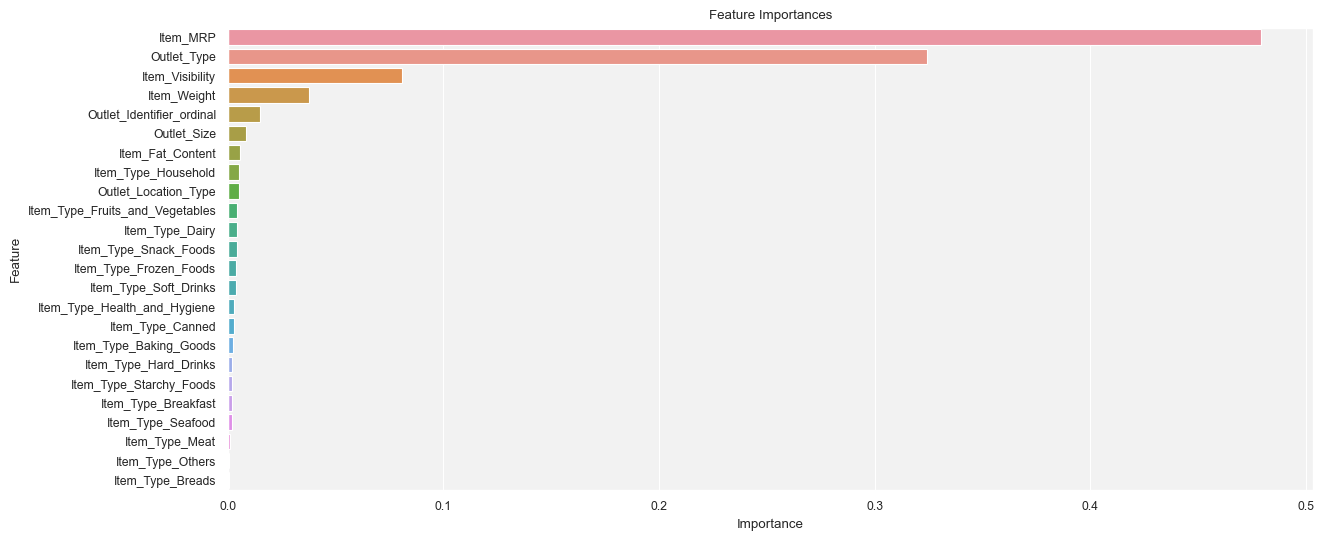

In [58]:
importances = tree_reg.feature_importances_
df_results = pd.DataFrame({'Feature': features_columns, 'Importance': importances}).sort_values(by=['Importance'], ascending=False)


plt.figure(figsize=(14, 6))

sns.barplot(data=df_results, x='Importance', y='Feature',)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

### Métricas de avaliação

**MAPE**

In [59]:
train_mape = mean_absolute_percentage_error(x_train_transformed['Outlet_Sales'], x_train_transformed['Predicted'])
test_mape = mean_absolute_percentage_error(x_test_transformed['Outlet_Sales'], x_test_transformed['Predicted'])

train_mape, test_mape

(0.23067101653582708, 0.6249749782796167)

**R²**

In [60]:
train_r2 = r2_score(x_train_transformed['Outlet_Sales'], x_train_transformed['Predicted'])
test_r2 = r2_score(x_test_transformed['Outlet_Sales'], x_test_transformed['Predicted'])

train_r2, test_r2

(0.8473488749438702, 0.361121475128126)

## 12) Testar diferentes modelos

**Decision Tree with Grid Search**

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [62]:
X = x_train_scaled
y = y_train

tree_reg = DecisionTreeRegressor()

param_grid = {
    'max_depth': [None, 5, 10, 15, 20, 50, 100],
    'min_samples_split': [2, 5, 10, 20, 40],
    'min_samples_leaf': [1, 2, 4, 6, 10, 20],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'splitter': ['best', 'random']
}

scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)


grid_search = GridSearchCV(tree_reg, param_grid, scoring=scorer, cv=5, n_jobs=-1)

grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 15, 20, 50, 100],
                         'max_features': [None, 'auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 6, 10, 20],
                         'min_samples_split': [2, 5, 10, 20, 40],
                         'splitter': ['best', 'random']},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))

In [63]:
print("Best parameters found: ", grid_search.best_params_)

print("Best score found: ", grid_search.best_score_)

Best parameters found:  {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 20, 'min_samples_split': 20, 'splitter': 'random'}
Best score found:  -0.5598448210535457


In [64]:
tree_reg = DecisionTreeRegressor(
    max_depth=grid_search.best_params_['max_depth'],
    max_features=grid_search.best_params_['max_features'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    splitter=grid_search.best_params_['splitter']
)

tree_reg.fit(X, y)

predicted_train = tree_reg.predict(X)
predicted_test = tree_reg.predict(x_test_scaled)

x_train_transformed['Outlet_Sales'] = y_train
x_test_transformed['Outlet_Sales'] = y_test

x_train_transformed['Predicted'] = predicted_train
x_test_transformed['Predicted'] = predicted_test

**MAPE**

In [65]:
train_mape = mean_absolute_percentage_error(x_train_transformed['Outlet_Sales'], x_train_transformed['Predicted'])
test_mape = mean_absolute_percentage_error(x_test_transformed['Outlet_Sales'], x_test_transformed['Predicted'])

train_mape, test_mape

(0.5468086688890537, 0.5414629272039345)

**R²**

In [66]:
train_r2 = r2_score(x_train_transformed['Outlet_Sales'], x_train_transformed['Predicted'])
test_r2 = r2_score(x_test_transformed['Outlet_Sales'], x_test_transformed['Predicted'])

train_r2, test_r2

(0.6087072672080875, 0.5936794250165923)

### 12.1) Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
X = x_train_scaled
y = y_train

rf_reg = DecisionTreeRegressor(max_depth=10)
rf_reg.fit(X, y)

predicted_train = rf_reg.predict(X)
predicted_test = rf_reg.predict(x_test_scaled)

x_train_transformed['Outlet_Sales'] = y_train
x_test_transformed['Outlet_Sales'] = y_test

x_train_transformed['Predicted'] = predicted_train
x_test_transformed['Predicted'] = predicted_test

In [ ]:
train_mape = round(mean_absolute_percentage_error(x_train_transformed['Outlet_Sales'], x_train_transformed['Predicted']), 3)
test_mape = round(mean_absolute_percentage_error(x_test_transformed['Outlet_Sales'], x_test_transformed['Predicted']), 3)
train_r2 = round(r2_score(x_train_transformed['Outlet_Sales'], x_train_transformed['Predicted']), 3)
test_r2 = round(r2_score(x_test_transformed['Outlet_Sales'], x_test_transformed['Predicted']), 3)

print('MAPE Results:')
print(f'Train: {train_mape}')
print(f'Test: {test_mape}')

print('\nR2 Results:')
print(f'Train: {train_r2}')
print(f'Test: {test_r2}')


In [ ]:
importances = tree_reg.feature_importances_
df_results = pd.DataFrame({'Feature': features_columns, 'Importance': importances}).sort_values(by=['Importance'], ascending=False)


plt.figure(figsize=(14, 6))

sns.barplot(data=df_results, x='Importance', y='Feature')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

### 12.2) LightGBM

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
params = {
    'num_leaves': 81,
    'n_estimators': 25,
    'max_depth': 10,
    'learning_rate': 0.1,
    'objective': 'regression_l2',
    'boosting_type': 'gbdt',
    'early_stopping_rounds': None,
}

In [ ]:
# weight = np.random.uniform(0, 3, size=6392)
weight = sample_weights = np.random.rand(len(X))
weight

In [ ]:
X = x_train_scaled
y = y_train

lgbm = LGBMRegressor(**params)
lgbm.fit(X, y, sample_weight=weight)

predicted_train = lgbm.predict(X)
predicted_test = lgbm.predict(x_test_scaled)

x_train_transformed['Outlet_Sales'] = y_train
x_test_transformed['Outlet_Sales'] = y_test

x_train_transformed['Predicted'] = predicted_train
x_test_transformed['Predicted'] = predicted_test

In [ ]:
train_mape = round(mean_absolute_percentage_error(x_train_transformed['Outlet_Sales'], x_train_transformed['Predicted']), 3)
test_mape = round(mean_absolute_percentage_error(x_test_transformed['Outlet_Sales'], x_test_transformed['Predicted']), 3)
train_r2 = round(r2_score(x_train_transformed['Outlet_Sales'], x_train_transformed['Predicted']), 3)
test_r2 = round(r2_score(x_test_transformed['Outlet_Sales'], x_test_transformed['Predicted']), 3)

print('MAPE Results:')
print(f'Train: {train_mape}')
print(f'Test: {test_mape}')

print('\nR2 Results:')
print(f'Train: {train_r2}')
print(f'Test: {test_r2}')


---
**Grid Search**

In [ ]:
lgbm = LGBMRegressor()

param_grid = {
    'num_leaves': [10, 20, 40, 50, 80, 100, 1000],
    'n_estimators': [10, 25, 45, 100],
    'max_depth': [10, 30, 50],
    'learning_rate': [0.1, 0.01, 0.001],
    'objective': ['mape'],
    'boosting_type': ['gbdt'],
}

scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)


grid_search = GridSearchCV(lgbm, param_grid, scoring=scorer, cv=5, n_jobs=-1)

grid_search.fit(X, y)

In [ ]:
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

In [ ]:
params = {
    'num_leaves': grid_search.best_params_['num_leaves'],
    'n_estimators': grid_search.best_params_['n_estimators'],
    'max_depth': grid_search.best_params_['max_depth'],
    'learning_rate': grid_search.best_params_['learning_rate'],
    'objective': grid_search.best_params_['objective'],
    'boosting_type': grid_search.best_params_['boosting_type'],
}

X = x_train_scaled
y = y_train

lgbm = LGBMRegressor(**params)
lgbm.fit(X, y)

predicted_train = lgbm.predict(X)
predicted_test = lgbm.predict(x_test_scaled)

x_train_transformed['Outlet_Sales'] = y_train
x_test_transformed['Outlet_Sales'] = y_test

x_train_transformed['Predicted'] = predicted_train
x_test_transformed['Predicted'] = predicted_test

In [ ]:
train_mape = round(mean_absolute_percentage_error(x_train_transformed['Outlet_Sales'], x_train_transformed['Predicted']), 3)
test_mape = round(mean_absolute_percentage_error(x_test_transformed['Outlet_Sales'], x_test_transformed['Predicted']), 3)
train_r2 = round(r2_score(x_train_transformed['Outlet_Sales'], x_train_transformed['Predicted']), 3)
test_r2 = round(r2_score(x_test_transformed['Outlet_Sales'], x_test_transformed['Predicted']), 3)

print('MAPE Results:')
print(f'Train: {train_mape}')
print(f'Test: {test_mape}')

print('\nR2 Results:')
print(f'Train: {train_r2}')
print(f'Test: {test_r2}')


### 12.3) XGBoost

In [ ]:
# !pip install xgboost

In [ ]:
import xgboost as xgb

In [ ]:
X = x_train_scaled
y = y_train

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X, y)

predicted_train = xgb_reg.predict(X)
predicted_test = xgb_reg.predict(x_test_scaled)

x_train_transformed['Outlet_Sales'] = y_train
x_test_transformed['Outlet_Sales'] = y_test

x_train_transformed['Predicted'] = predicted_train
x_test_transformed['Predicted'] = predicted_test

In [ ]:
train_mape = round(mean_absolute_percentage_error(x_train_transformed['Outlet_Sales'], x_train_transformed['Predicted']), 3)
test_mape = round(mean_absolute_percentage_error(x_test_transformed['Outlet_Sales'], x_test_transformed['Predicted']), 3)
train_r2 = round(r2_score(x_train_transformed['Outlet_Sales'], x_train_transformed['Predicted']), 3)
test_r2 = round(r2_score(x_test_transformed['Outlet_Sales'], x_test_transformed['Predicted']), 3)

print('MAPE Results:')
print(f'Train: {train_mape}')
print(f'Test: {test_mape}')

print('\nR2 Results:')
print(f'Train: {train_r2}')
print(f'Test: {test_r2}')

### 12.4) SVM (Support Vector Machine)

In [ ]:
from sklearn.svm import SVR

In [ ]:
X = x_train_scaled
y = y_train

svm_reg = SVR()
svm_reg.fit(X, y)

predicted_train = svm_reg.predict(X)
predicted_test = svm_reg.predict(x_test_scaled)

x_train_transformed['Outlet_Sales'] = y_train
x_test_transformed['Outlet_Sales'] = y_test

x_train_transformed['Predicted'] = predicted_train
x_test_transformed['Predicted'] = predicted_test

In [ ]:
train_mape = round(mean_absolute_percentage_error(x_train_transformed['Outlet_Sales'], x_train_transformed['Predicted']), 3)
test_mape = round(mean_absolute_percentage_error(x_test_transformed['Outlet_Sales'], x_test_transformed['Predicted']), 3)
train_r2 = round(r2_score(x_train_transformed['Outlet_Sales'], x_train_transformed['Predicted']), 3)
test_r2 = round(r2_score(x_test_transformed['Outlet_Sales'], x_test_transformed['Predicted']), 3)

print('MAPE Results:')
print(f'Train: {train_mape}')
print(f'Test: {test_mape}')

print('\nR2 Results:')
print(f'Train: {train_r2}')
print(f'Test: {test_r2}')

## 13) Ajustar Hiperparâmetros

In [ ]:
xgb_reg = xgb.XGBRegressor()

param_grid = {
    'booster': ['gbtree', 'gblinear', 'dart'],
    'eta': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [2,8,12,15,20],
    'min_child_weight': [1,2,5],
    # 'lambda': [0, 0.1, 0.5, 1],
    # 'alpha': [0, 0.1, 0.5, 1],
    # 'max_leaves': [0,1,4],
    # 'max_bin': [10, 100, 256, 512]
}

scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)


grid_search = GridSearchCV(xgb_reg, param_grid, scoring=scorer, cv=5, n_jobs=-1)

grid_search.fit(X, y)

In [ ]:
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

In [ ]:
params = {
    'booster': grid_search.best_params_['booster'],
    'eta': grid_search.best_params_['eta'],
    'max_depth': grid_search.best_params_['max_depth'],
    'min_child_weight': grid_search.best_params_['min_child_weight'],
}

X = x_train_scaled
y = y_train

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X, y)

predicted_train = xgb_reg.predict(X)
predicted_test = xgb_reg.predict(x_test_scaled)

x_train_transformed['Outlet_Sales'] = y_train
x_test_transformed['Outlet_Sales'] = y_test

x_train_transformed['Predicted'] = predicted_train
x_test_transformed['Predicted'] = predicted_test

In [ ]:
train_mape = round(mean_absolute_percentage_error(x_train_transformed['Outlet_Sales'], x_train_transformed['Predicted']), 3)
test_mape = round(mean_absolute_percentage_error(x_test_transformed['Outlet_Sales'], x_test_transformed['Predicted']), 3)
train_r2 = round(r2_score(x_train_transformed['Outlet_Sales'], x_train_transformed['Predicted']), 3)
test_r2 = round(r2_score(x_test_transformed['Outlet_Sales'], x_test_transformed['Predicted']), 3)

print('MAPE Results:')
print(f'Train: {train_mape}')
print(f'Test: {test_mape}')

print('\nR2 Results:')
print(f'Train: {train_r2}')
print(f'Test: {test_r2}')

# Fim

In [68]:
x_train_transformed.drop(columns=['Predicted'], inplace=True)
x_test_transformed.drop(columns=['Predicted'], inplace=True)

In [69]:
x_train_transformed.to_parquet('../data/x_train_transformed.parquet', compression='gzip', engine='pyarrow')
x_test_transformed.to_parquet('../data/x_test_transformed.parquet', compression='gzip', engine='pyarrow')